# Sentiment analysis

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
import nltk
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from transformers import pipeline
from scipy.special import softmax
from sentence_transformers import SentenceTransformer, util
from scipy.interpolate import interp1d

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\march\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [94]:
DATA_PATH = "../../data/our_movie_data_extended.csv"
df_extended = pd.read_csv(DATA_PATH)[["Wikipedia_movie_ID", "summary", "category"]]
df_extended.dropna(subset=["summary"], inplace=True)
df_extended.sample(3)

,Wikipedia_movie_ID,summary,category
8219,2423947,The film opens with the band performing at th...,"['Comedy', 'Others']"
44846,19698524,A Man awakens one morning with a hangover to ...,"['Thriller', 'Horror', 'Others']"
35812,14503425,The Stooges help a destitute mother and her da...,"['Comedy', 'Others']"


### Version of sentiment analysis using emotions and segments

In [9]:
device = 0 if torch.cuda.is_available() else 'cpu'

In [ ]:
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True, device=device)
sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)

big_df = pd.DataFrame()

limit = 2 # You can adjust the limit as needed
threshold = 0.5

#iterate over summaries
for idx, t in tqdm(df_extended['summary'].iloc[:limit].items(), total=len(df_extended['summary'].iloc[:limit])):
    sentences = nltk.sent_tokenize(t)
    embeddings = sentence_model.encode(sentences, convert_to_tensor=True)

    # Segment the text based on cosine similarity
    segments = []
    current_segment = [sentences[0]]

    for i in range(len(sentences) - 1):
        similarity = util.pytorch_cos_sim(embeddings[i], embeddings[i + 1]).item()

        if similarity < threshold:
            segments.append(" ".join(current_segment))
            current_segment = []

        current_segment.append(sentences[i + 1])

    #final segment join
    segments.append(" ".join(current_segment))

    # Classify the segments for emotions
    out = classifier(segments)
    emotions_flattened = [{item['label']: item['score'] for item in entry} for entry in out]
    emotions = pd.DataFrame(emotions_flattened)

    emotions['segment_id'] = [i for i in range(len(segments))]
    emotions['segment'] = [segments[i] for i in range(len(segments))]
    emotions['Wikipedia_movie_ID'] = [df_extended.iloc[idx]['Wikipedia_movie_ID']] * len(emotions)
    
    big_df = pd.concat([big_df, emotions], ignore_index=True)

print(big_df.shape)

c:\Users\march\anaconda3\envs\ada\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

(19, 10)


### Version of sentiment analysis using sentences and emotions

In [ ]:
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True, device=device)
big_df = pd.DataFrame()

limit = 2 # You can adjust the limit as needed

for idx, t in tqdm(df_extended['summary'].iloc[:limit].items(), total=len(df_extended['summary'].iloc[:limit])):
    sentences = nltk.sent_tokenize(t)

    out = classifier(sentences)

    emotions_flattened = [{item['label']: item['score'] for item in entry} for entry in out]
    emotions = pd.DataFrame(emotions_flattened)

    emotions['sentence_id'] = [i for i in range(len(sentences))]
    emotions['sentence'] = [sentences[i] for i in range(len(sentences))]
    emotions['Wikipedia_movie_ID'] = [df_extended.iloc[idx]['Wikipedia_movie_ID']] * len(emotions) 

    big_df = pd.concat([big_df, emotions], ignore_index=True)
print(big_df.shape)

c:\Users\march\anaconda3\envs\ada\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

(25, 10)


### Version of sentiment analysis using positive/negative only

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
dict_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}

big_df = pd.DataFrame()

limit = 10 # You can adjust the limit as needed

for idx, t in tqdm(df_extended['summary'].iloc[:limit].items(), total=len(df_extended['summary'].iloc[:limit])):
    sentences = nltk.sent_tokenize(t)
    for idx_s, s in enumerate(sentences):
        t_encoded = tokenizer(s, return_tensors='pt')
        t_output = model(**t_encoded)
        scores = softmax(t_output.logits.detach().numpy(), axis=1)
        
        emotions = pd.DataFrame(scores, columns=[dict_labels[i] for i in range(3)])
        emotions['sentence_id'] = idx_s
        emotions['Wikipedia_movie_ID'] = [df_extended.iloc[idx]['Wikipedia_movie_ID']] * len(emotions) 

        big_df = pd.concat([big_df, emotions], ignore_index=True)
print(big_df.shape)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 10/10 [00:14<00:00,  1.50s/it]

(297, 5)


In [48]:
big_df.head(20)

,negative,neutral,positive,sentence_id,Wikipedia_movie_ID
0,0.005653,0.821786,0.172561,0,330
1,0.255226,0.724555,0.020220,0,3217
2,0.755420,0.235866,0.008714,1,3217
3,0.110220,0.838336,0.051444,2,3217
4,0.119391,0.574379,0.306231,3,3217
5,0.005951,0.482136,0.511913,4,3217
6,0.013369,0.838581,0.148051,5,3217
7,0.027470,0.903485,0.069045,6,3217
8,0.046110,0.917408,0.036482,7,3217
9,0.138054,0.813180,0.048766,8,3217


# Analyzing results

In [114]:
DATA_PATH = "../../data/sentence_emotions_5000.csv"
DATA_PATH_MOVIE_METADATA = "../../data/our_movie_data_extended.pkl"
df_emotions = pd.read_csv(DATA_PATH)
with open(DATA_PATH_MOVIE_METADATA, 'rb') as f:
    df_metadata = pickle.load(f)
df_metadata.sample(1)

,Wikipedia_movie_ID,summary,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,category,continent
67244,29823665,NaN,/m/0fq13dc,Crucero de verano,NaN,NaN,NaN,Italian Language,Italy,"Comedy film, Musical","[Comedy, Musical]",Europe


In [102]:
target_timesteps = 20
emotions = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
def interpolate_emotions(movie_data, target_timesteps):
    
    original_positions = np.arange(len(movie_data))
    target_positions = np.linspace(0, len(movie_data) - 1, target_timesteps)

    interpolated_data = {emotion: [] for emotion in emotions}
    interpolated_data["Wikipedia_movie_ID"] = [movie_data["Wikipedia_movie_ID"].iloc[0]] * target_timesteps
    
    for emotion in emotions:
        interp_function = interp1d(original_positions, movie_data[emotion], kind="linear", fill_value="extrapolate")
        interpolated_data[emotion] = interp_function(target_positions)

    return pd.DataFrame(interpolated_data)

In [103]:
interpolated_movies = []
for movie_id, movie_data in df.groupby("Wikipedia_movie_ID"):
    interpolated_movie = interpolate_emotions(movie_data, target_timesteps)
    interpolated_movies.append(interpolated_movie)

interpolated_df = pd.concat(interpolated_movies, ignore_index=True)
interpolated_df['timestep'] = interpolated_df.groupby("Wikipedia_movie_ID").cumcount()

c:\Users\march\anaconda3\envs\ada\Lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [104]:
# The NaN are due to the extrapolation on single sentence summaries (we should get rif of them and scrape)
interpolated_df.isna().sum()

anger                 760
disgust               760
fear                  760
joy                   760
neutral               760
sadness               760
surprise              760
Wikipedia_movie_ID      0
timestep                0
dtype: int64

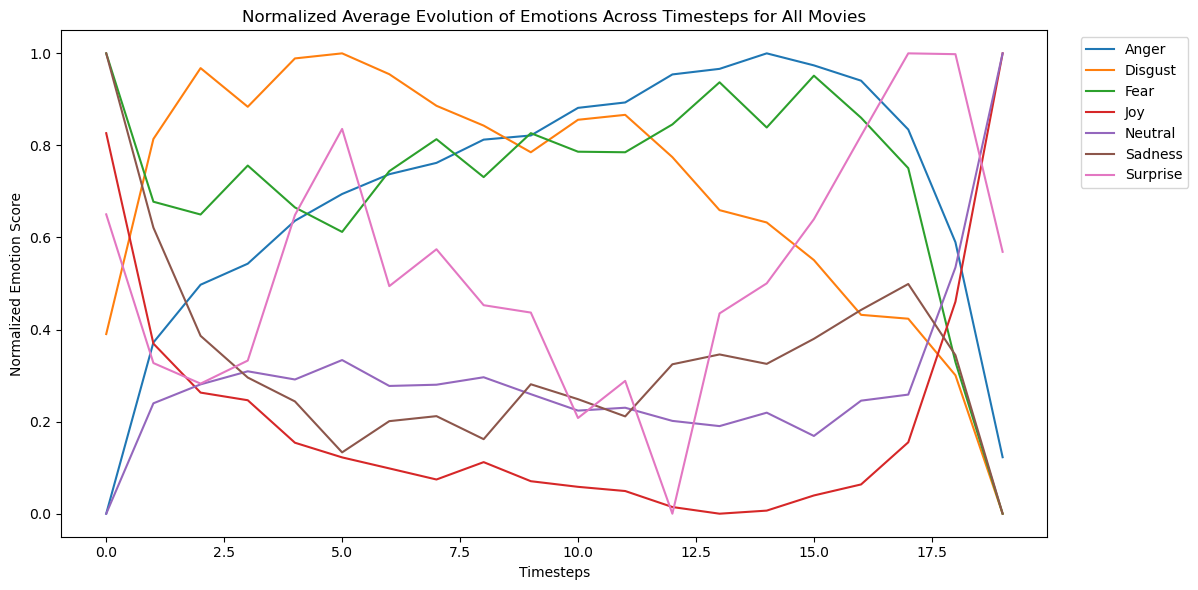

In [105]:
emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
avg_emotions = interpolated_df.groupby("timestep")[emotions].mean()

avg_emotions = avg_emotions[:target_timesteps]

#MinMax Normalization
normalized_emotions = avg_emotions.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

#ZScore Normalization
#normalized_emotions= avg_emotions.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

plt.figure(figsize=(12, 6))
for emotion in emotions:
    plt.plot(range(target_timesteps), normalized_emotions[emotion], label=emotion.capitalize())

plt.title("Normalized Average Evolution of Emotions Across Timesteps for All Movies")
plt.xlabel("Timesteps")
plt.ylabel("Normalized Emotion Score")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

### Now we can try for movies in already formed genres

In [ ]:
df_exploded = interpolated_df.merge(df_metadata[["Wikipedia_movie_ID","category"]], on="Wikipedia_movie_ID")
df_exploded = df_exploded.explode("category")
df_grouped_by_genre = df_exploded.groupby("category")


In [128]:
df_grouped_by_genre = df_exploded.groupby(["category", "timestep"])[emotions].mean()
df_grouped_by_genre


anger   disgust      fear       joy   neutral  \
category         timestep                                                     
Action/Adventure 0         0.066540  0.158170  0.115147  0.136765  0.312444   
                 1         0.106388  0.179040  0.097174  0.090381  0.343654   
                 2         0.112624  0.192289  0.095612  0.080071  0.352053   
                 3         0.116872  0.189911  0.105522  0.078756  0.344649   
                 4         0.128178  0.202720  0.096689  0.068721  0.349219   
...                             ...       ...       ...       ...       ...   
War/Crime        15        0.154698  0.151563  0.112976  0.061043  0.347516   
                 16        0.147422  0.149593  0.107858  0.065546  0.357334   
                 17        0.148052  0.151862  0.118026  0.071572  0.333238   
                 18        0.113019  0.137654  0.089043  0.102427  0.385446   
                 19        0.069492  0.131706  0.080817  0.144945  0.426901   

                            sadness  surprise  
category         timestep                      
Action/Adventure 0         0.169829  0.041105  
                 1         0.142573  0.040790  
                 2         0.129488  0.037864  
                 3         0.122697  0.041592  
                 4         0.115827  0.038646  
...                             ...       ...  
War/Crime        15        0.131647  0.040559  
                 16        0.127632  0.044616  
                 17        0.134150  0.043101  
                 18        0.123950  0.048461  
                 19        0.109439  0.036700  

[280 rows x 7 columns]

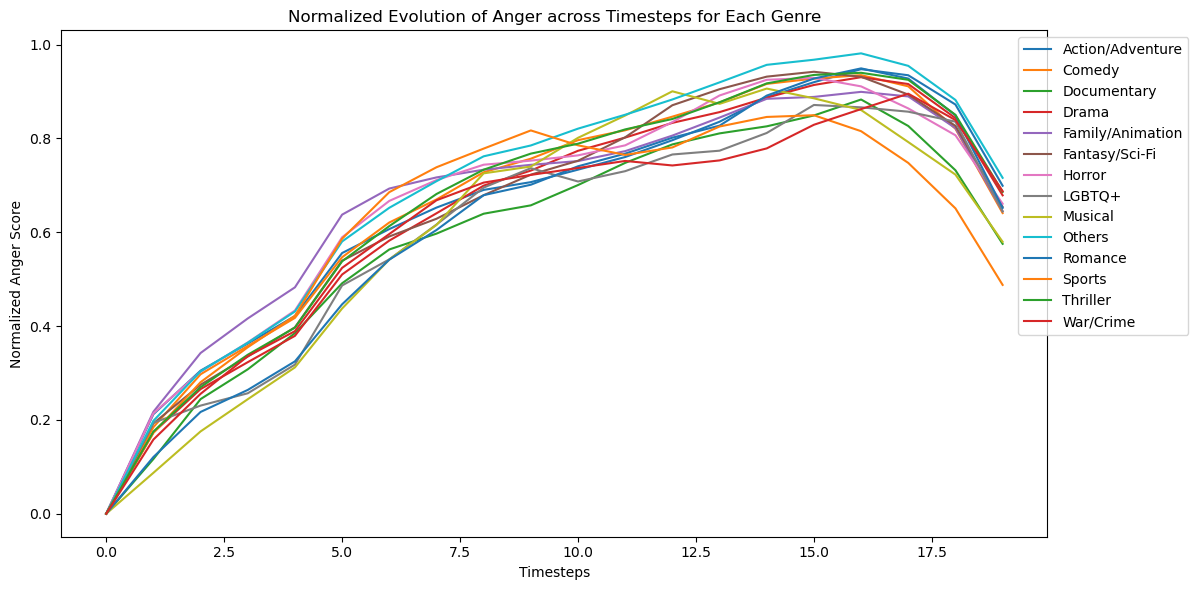

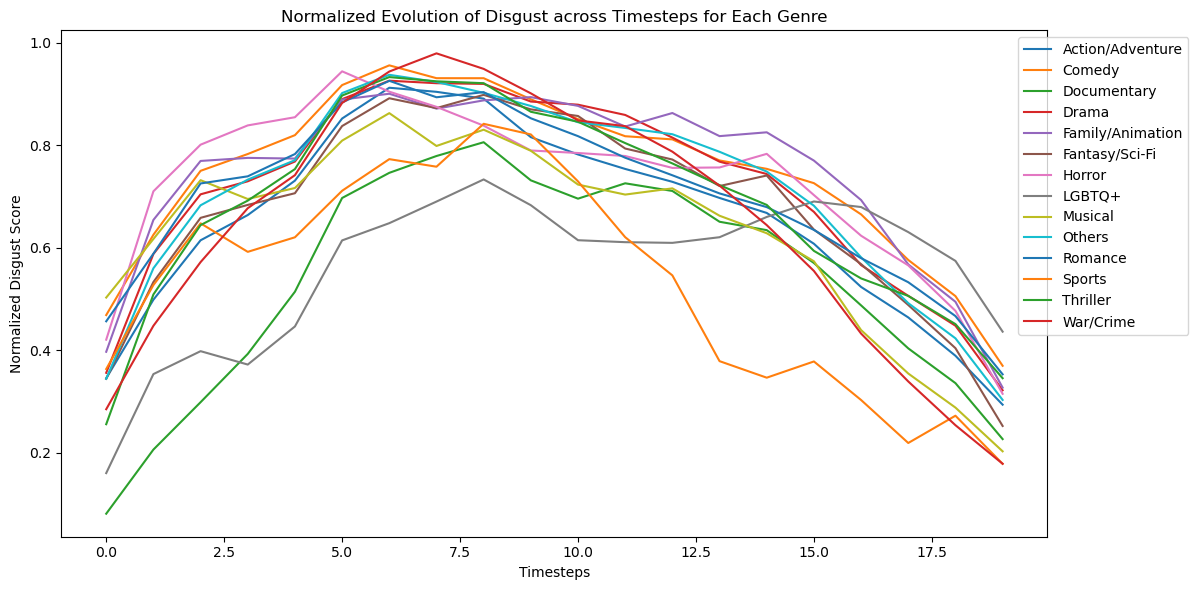

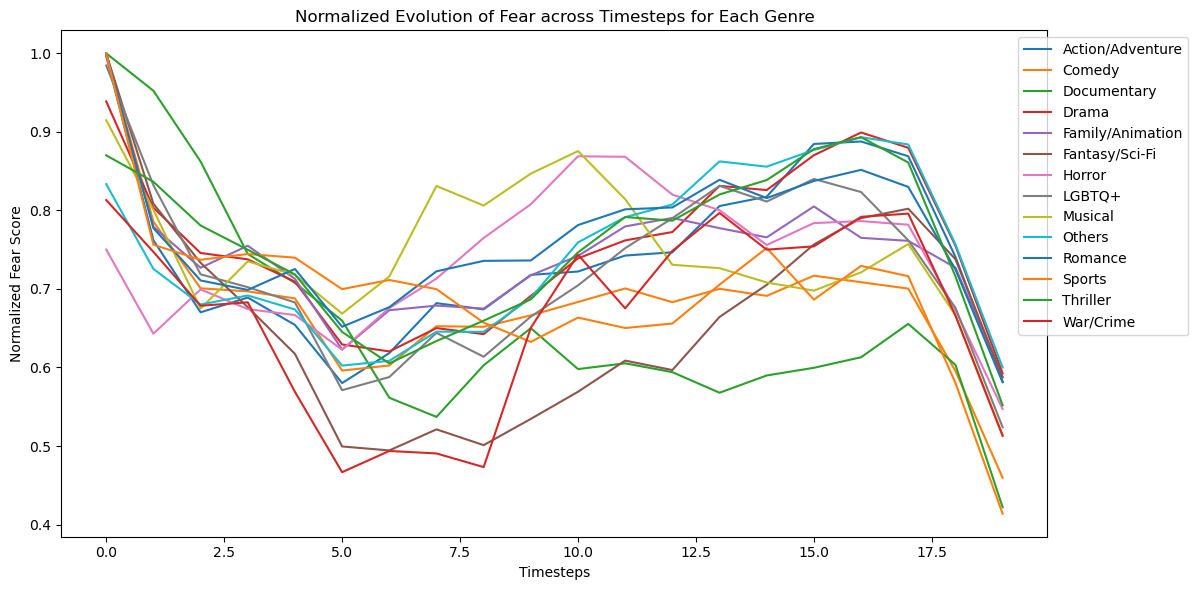

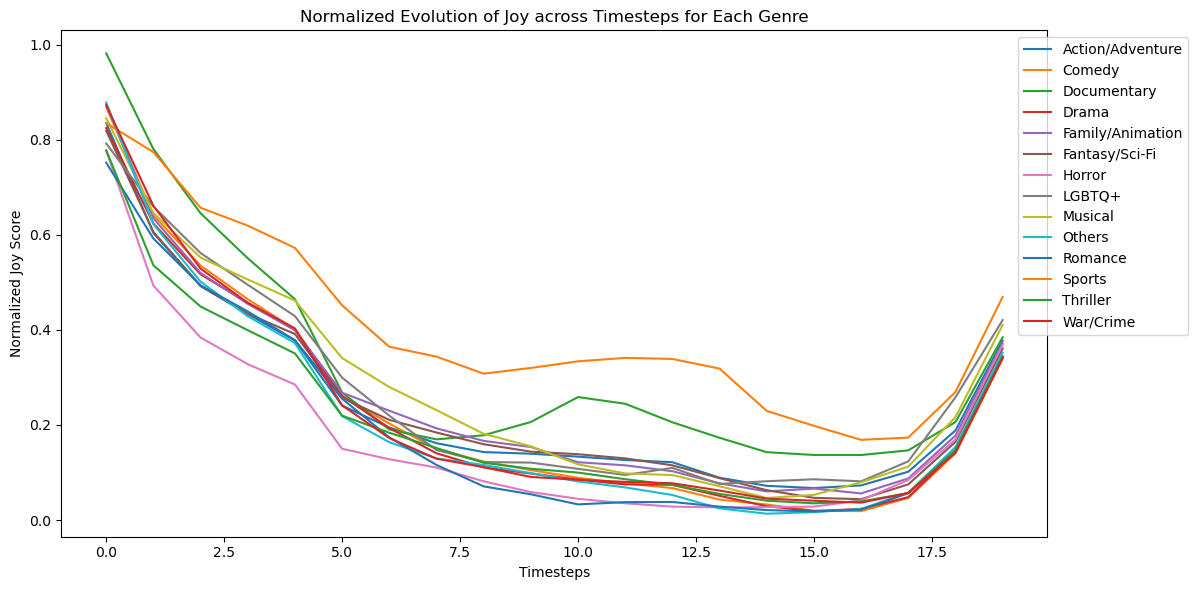

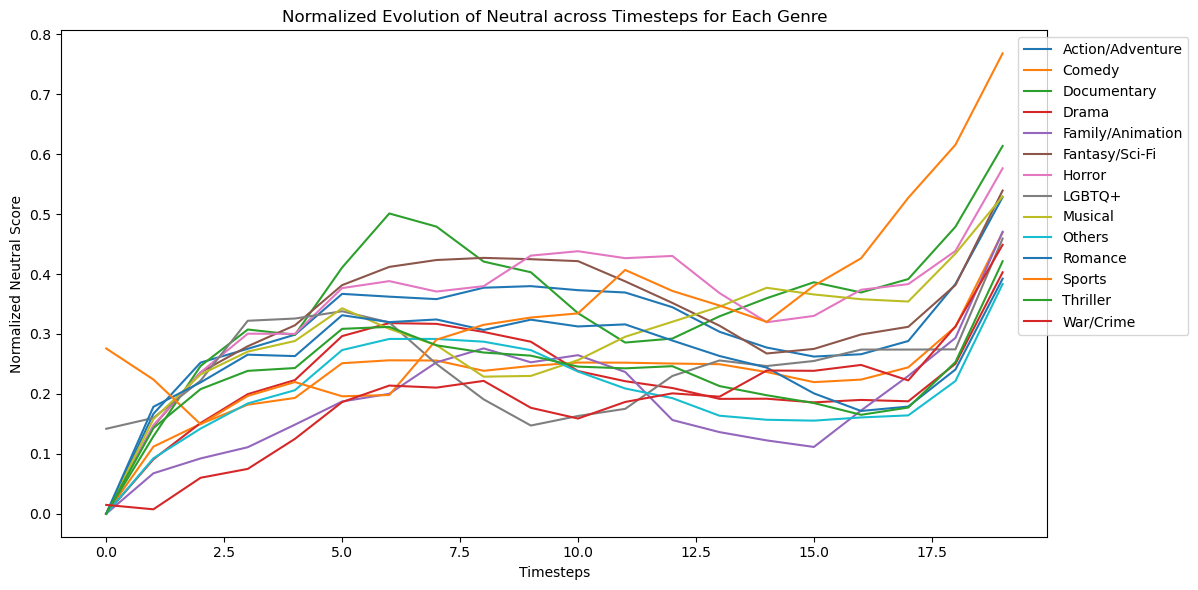

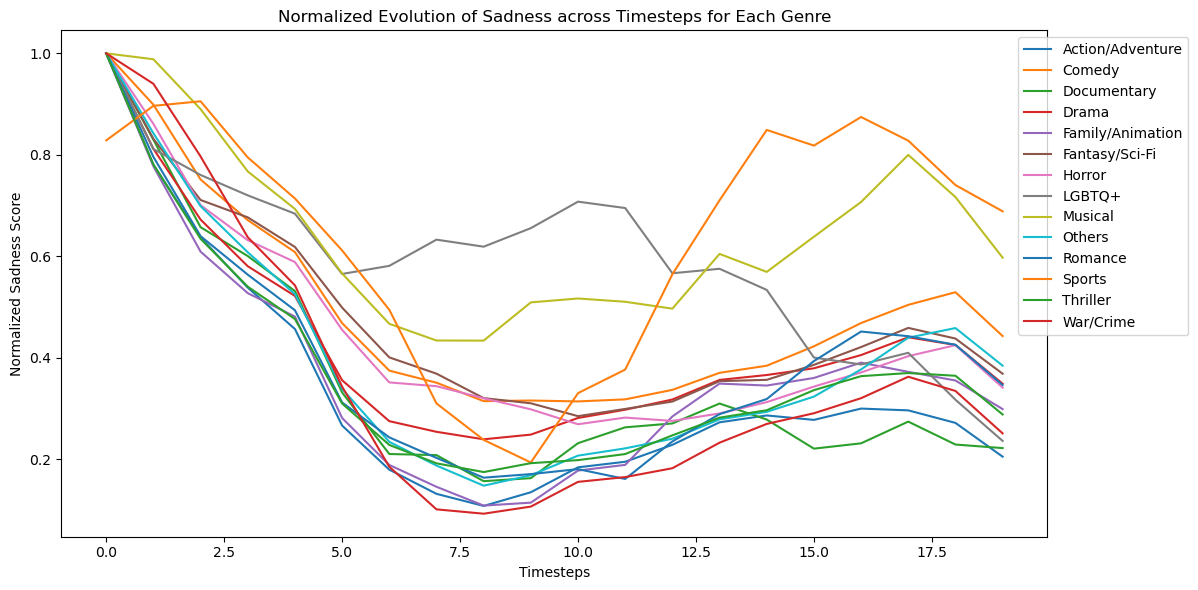

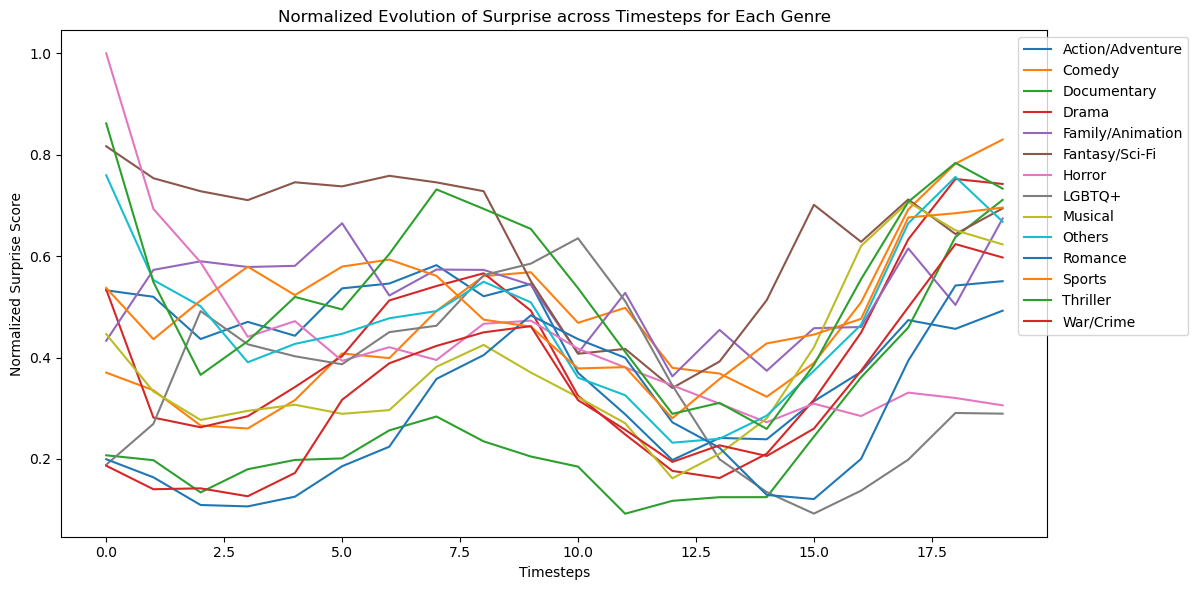

In [138]:
window_size = 5
for emotion in emotions:
    plt.figure(figsize=(12, 6))
    
    avg_emotion_by_genre = df_grouped_by_genre[emotion].unstack(level=0)

    avg_emotion_by_genre = avg_emotion_by_genre.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
    
    smoothed_avg_emotion_by_genre = avg_emotion_by_genre.rolling(window=window_size, min_periods=1).mean()

    for genre in smoothed_avg_emotion_by_genre.columns:
        plt.plot(smoothed_avg_emotion_by_genre.index, smoothed_avg_emotion_by_genre[genre], label=genre)
    
    plt.title(f"Normalized Evolution of {emotion.capitalize()} across Timesteps for Each Genre")
    plt.xlabel("Timesteps")
    plt.ylabel(f"Normalized {emotion.capitalize()} Score")
    plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
    plt.tight_layout()
    plt.show()
    